## Part 2 - Deep Learning and Clustering of Image Data

In [28]:
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
import requests
import os
import tarfile

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, adjusted_rand_score, adjusted_mutual_info_score
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin

# !pip install hdbscan
from hdbscan import HDBSCAN

from sklearn.manifold import TSNE

from sklearn.model_selection import train_test_split
# !pip install umap-learn[plot]
# !pip install holoviews
# !pip install -U ipykernel

import umap
import umap.plot

from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics.cluster import rand_score


from sklearn.cluster import KMeans
from sklearn.metrics.cluster import contingency_matrix

from sklearn.metrics.cluster import homogeneity_score
from sklearn.metrics.cluster import completeness_score
from sklearn.metrics.cluster import v_measure_score
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics.cluster import adjusted_mutual_info_score


from scipy.optimize import linear_sum_assignment
from sklearn.metrics import confusion_matrix
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.decomposition import TruncatedSVD

# Flowers Dataset and VGG Features

### Question 19

If the VGG network is trained on a dataset with different classes as targets, the features derived from that model are expected to have discriminative power for a custom dataset is quite true only when the VGG netowrk is trained on a relatively large dataset compared to the custom data in consideration and also the dataset on which VGG was trained has to be of some relevance to the custom dataset. One can't expect the features extracted from a VGG network trained on a Speech data to perform and to be used on a custom dataset of images.

Also given the above conditions are met one can expect the VGG extracted features to have a discriminative power for custom dataset because the features learned by the network are generalized features for a class of data which are universal for the object.  

In [2]:
filename = './flowers_features_and_labels.npz'

if os.path.exists(filename):
    file = np.load(filename)
    f_all, y_all = file['f_all'], file['y_all']

else:
    if not os.path.exists('./flower_photos'):
        # download the flowers dataset and extract its images
        url = 'http://download.tensorflow.org/example_images/flower_photos.tgz'
        with open('./flower_photos.tgz', 'wb') as file:
            file.write(requests.get(url).content)
        with tarfile.open('./flower_photos.tgz') as file:
            file.extractall('./')
        os.remove('./flower_photos.tgz')

    class FeatureExtractor(nn.Module):
        def __init__(self):
            super().__init__()

            vgg = torch.hub.load('pytorch/vision:v0.10.0', 'vgg16', pretrained=True)

            # Extract VGG-16 Feature Layers
            self.features = list(vgg.features)
            self.features = nn.Sequential(*self.features)
            # Extract VGG-16 Average Pooling Layer
            self.pooling = vgg.avgpool
            # Convert the image into one-dimensional vector
            self.flatten = nn.Flatten()
            # Extract the first part of fully-connected layer from VGG16
            self.fc = vgg.classifier[0]

        def forward(self, x):
            # It will take the input 'x' until it returns the feature vector called 'out'
            out = self.features(x)
            out = self.pooling(out)
            out = self.flatten(out)
            out = self.fc(out) 
            return out 

    # Initialize the model
    assert torch.cuda.is_available()
    feature_extractor = FeatureExtractor().cuda().eval()

    dataset = datasets.ImageFolder(root='./flower_photos',
                                   transform=transforms.Compose([transforms.Resize(224),
                                                                 transforms.CenterCrop(224),
                                                                 transforms.ToTensor(),
                                                                 transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]))
    dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

    # Extract features and store them on disk
    f_all, y_all = np.zeros((0, 4096)), np.zeros((0,))
    for x, y in tqdm(dataloader):
        with torch.no_grad():
            f_all = np.vstack([f_all, feature_extractor(x.cuda()).cpu()])
            y_all = np.concatenate([y_all, y])
    np.savez(filename, f_all=f_all, y_all=y_all)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
100%|██████████| 58/58 [00:55<00:00,  1.04it/s]


In [3]:
print(f_all.shape, y_all.shape)
num_features = f_all.shape[1]

(3670, 4096) (3670,)


### Question 20

How features are extracted:
- The custom dataset is loaded via dataloader from the directory.
- While being loaded each image is preprocessed with resizing and cropping (for same size of images), then they are converted to tensors and normalized for faster convergence.

- Then all the code is doing is to pass these images in batches to the Feature extractor which is initialized with VGG extracted features, leaving the dense layers which do the predictions.

- Each image does a forward pass through the VGG features, then it's passed through pooling layer and flattened and appened to a numpy array as (1 X 4096) size row vector.

- When the forward pass of image is done, the pretrained model extracts the features from the image.

Size of dataset:  3670
Classes in dataset ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
Viewing a random image::: 
Size of original image 1:  (320, 239)
Size of original image 2:  (500, 334)
Size of original image 3:  (500, 375)
Size of original image 4:  (500, 331)


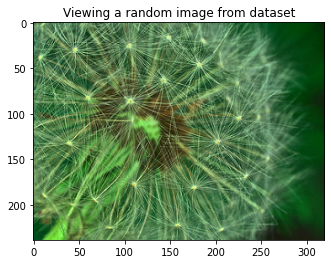

In [4]:
# Finding the size of original images.
# Fetching a few from the original dataset saved under folder flower_photos

imageData = datasets.ImageFolder(root='./flower_photos')
print("Size of dataset: ", len(imageData))

print("Classes in dataset", imageData.classes)

print("Viewing a random image::: ")

image, label = imageData[np.random.randint(len(imageData))]
plt.imshow(image)

plt.title("Viewing a random image from dataset")

print("Size of original image 1: ", image.size)

# More rrandomly selected image.
image, label = imageData[np.random.randint(len(imageData))]
print("Size of original image 2: ", image.size)

image, label = imageData[np.random.randint(len(imageData))]
print("Size of original image 3: ", image.size)

image, label = imageData[np.random.randint(len(imageData))]
print("Size of original image 4: ", image.size)

### Question 21

There are varying amount of pixels in the original dataset. <br>

The sizes are all different, each image has three channels and different dimensions as shown above(320, 239), (500, 334), (500, 375) etc.. thats why while being loaded by dataloader, the cropping and resisizing is done to make them of same size.

For each image 4096 features are extracted.

Each image then is represented as a (1 x 4096) row vector.

Question 22

In [5]:
TFIDFRepresentations = np.array(fullFeatures.toarray())
averageZeros = np.mean((TFIDFRepresentations.shape[1] - np.count_nonzero(TFIDFRepresentations, axis=0)))
sparsity = averageZeros * 100/ TFIDFRepresentations.shape[1]
print("On average every TFIDF Representation of news data is {} % sparse".format(sparsity))

On average every TFIDF Representation of news data is 99.92301584390873 % sparse


In [6]:
# Sparsity check of VGG Features.
averageZerosVGG = np.mean((f_all.shape[1] - np.count_nonzero(f_all, axis=0)))
print(averageZerosVGG * 100/ f_all.shape[1])

10.400390625


In [7]:
print("On average every Image feature Representation is {} % sparse".format(10.400390625))

On average every Image feature Representation is 10.400390625 % sparse


#### Answer 22

The extracted features are around 10.400 % sparse i.e. around ~410 zeros per 4096 entries. 
We can't call these sparse but somewhat dense.

For the TF-IDF representations of the news data:
They are 99.92 % sparse. Which is huge and highly sparse.

Text(0.5, 1.0, 'Plotting extracted VGG features')

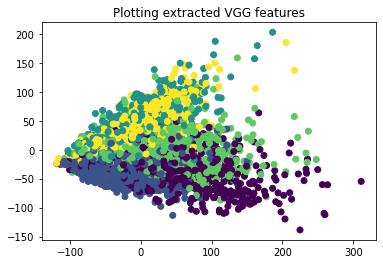

In [8]:
f_pca = PCA(n_components=2).fit_transform(f_all)
plt.scatter(*f_pca.T, c=y_all)
plt.title("Plotting extracted VGG features")

### Question 23

In [9]:
# Visualisation using TSNE

tsneMod = TSNE(n_components=2, n_iter=2000, init='random', learning_rate='auto')
tsne_results = tsneMod.fit_transform(f_all)

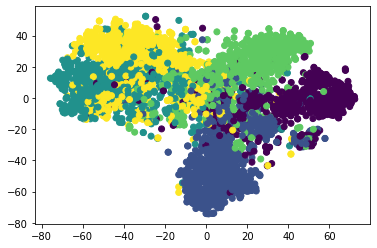

In [10]:
plt.scatter(*tsne_results.T, c=y_all)

#### Answer 23

The TSNE representation of the flower data is shown above.

We can see that the extracted features are quite well separated in the 2-D space mapping done by TSNE.

# MLP Classifier

In [47]:
class MLP(torch.nn.Module):
    def __init__(self, num_features):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(num_features, 1280),
            nn.ReLU(True),
            nn.Linear(1280, 640),
            nn.ReLU(True), 
            nn.Linear(640, 5),
            nn.LogSoftmax(dim=1)
        )
        self.cuda()
    
    
    def forward(self, X):
        return self.model(X)
    
    def train(self, X, y):
        X = torch.tensor(X, dtype=torch.float32, device='cuda')
        y = torch.tensor(y, dtype=torch.int64, device='cuda')
        lossHistory = []
        self.model.train()
        
        criterion = nn.NLLLoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-5)

        dataset = TensorDataset(X, y)
        dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

        for epoch in tqdm(range(100)):
            for (X_, y_) in dataloader:
                out=self.forward(X_)
                loss=criterion(out,y_)
                lossHistory.append(loss)
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
        return self, lossHistory
    
    def eval(self, X_test, y_test):
      X_tensor = torch.tensor(X_test, dtype=torch.float32, device='cuda')
      y_tensor = torch.tensor(y_test, dtype=torch.int64, device='cuda')
      scores = self.forward(X_tensor)
      print(scores.shape)
      _, pred = torch.max(scores.data, 1)
      pred = pred.cpu().detach().numpy()
      print(pred.shape)
      print("Accuracy:", accuracy_score(y_test, pred))
      print("Precision:", precision_score(y_test, pred,average='macro'))
      print("Recall:", recall_score(y_test, pred, average='macro'))
      print("F1 Score:", f1_score(y_test, pred, average='macro'))
      acc=accuracy_score(y_test, pred)
      return {
          'accuracy': acc,
          'predictions': pred
      }

# Autoencoder

In [12]:
class Autoencoder(torch.nn.Module, TransformerMixin):
    def __init__(self, n_components):
        super().__init__()
        self.n_components = n_components
        self.n_features = None  # to be determined with data
        self.encoder = None
        self.decoder = None
        
    def _create_encoder(self):
        return nn.Sequential(
            nn.Linear(4096, 1280),
            nn.ReLU(True),
            nn.Linear(1280, 640),
            nn.ReLU(True), nn.Linear(640, 120), nn.ReLU(True), nn.Linear(120, self.n_components))
    
    def _create_decoder(self):
        return nn.Sequential(
            nn.Linear(self.n_components, 120),
            nn.ReLU(True),
            nn.Linear(120, 640),
            nn.ReLU(True),
            nn.Linear(640, 1280),
            nn.ReLU(True), nn.Linear(1280, 4096))
    
    def forward(self, X):
        encoded = self.encoder(X)
        decoded = self.decoder(encoded)
        return decoded
    
    def fit(self, X):
        X = torch.tensor(X, dtype=torch.float32, device='cuda')
        self.n_features = X.shape[1]
        self.encoder = self._create_encoder()
        self.decoder = self._create_decoder()
        self.cuda()
        self.train()
        
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-5)

        dataset = TensorDataset(X)
        dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

        for epoch in tqdm(range(100)):
            for (X_,) in dataloader:
                X_ = X_.cuda()
                # ===================forward=====================
                output = self(X_)
                loss = criterion(output, X_)
                # ===================backward====================
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        return self     
        
    def transform(self, X):
        X = torch.tensor(X, dtype=torch.float32, device='cuda')
        self.eval()
        with torch.no_grad():
            return self.encoder(X).cpu().numpy()

100%|██████████| 100/100 [00:48<00:00,  2.05it/s]


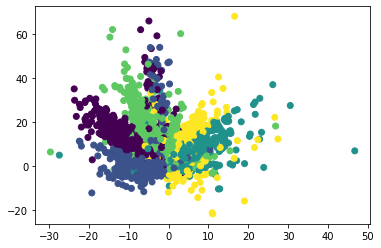

In [13]:
X_em =Autoencoder(2).fit_transform(f_all)
plt.scatter(*X_em.T, c=y_all)

### Question 24

**Clustering the Images via VGG Extracted features**

In [29]:
def getScores(true, predicted):
    scores = {}
    scores["Homogeneity"] = homogeneity_score(true, predicted)
    scores["Completeness"] = completeness_score(true, predicted)
    scores["V-measure"] = v_measure_score(true, predicted)
    scores["Adjusted Rand Index"] = adjusted_rand_score(true, predicted)
    scores["Adjusted mutual information score"] = adjusted_mutual_info_score(true, predicted)
    scores["Rand Score"] = rand_score(true, predicted)
    
    return scores

def getSVD(n_comp, data):
    SVD = TruncatedSVD(n_components=n_comp, random_state=42)
    SVD.fit(data)
    return SVD

In [15]:
VGGFeatures = f_all

# Dimensionality reduction using SVD, Autoencoder, UMAP to 50 components

SVDVGG = getSVD(50, VGGFeatures).transform(VGGFeatures)
UMAPVGG = umap.UMAP(n_components=50, random_state=42, metric='cosine').fit_transform(VGGFeatures)
AutoVGG = Autoencoder(50).fit_transform(VGGFeatures)

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)
100%|██████████| 100/100 [00:48<00:00,  2.05it/s]


In [16]:
reductionMap = {
    0: VGGFeatures,
    1: SVDVGG,
    2: UMAPVGG,
    3: AutoVGG
}

In [30]:
# Kmeans clustering

KmeanScores = {}

for i in range(len(reductionMap)):
  VGGkmeans = KMeans(n_clusters=5, random_state=42, max_iter=5000, n_init=50)
  VGGkmeans.fit(reductionMap[i])

  labels = VGGkmeans.labels_

  KmeanScores[i] = getScores(y_all, labels)

In [31]:
KmeanScores

{0: {'Homogeneity': 0.32900498422322894,
  'Completeness': 0.3647476844761788,
  'V-measure': 0.3459555878942219,
  'Adjusted Rand Index': 0.1909980740775149,
  'Adjusted mutual information score': 0.34501522579192423,
  'Rand Score': 0.7028579534103762},
 1: {'Homogeneity': 0.33000487503166903,
  'Completeness': 0.3654963545562431,
  'V-measure': 0.346845048372751,
  'Adjusted Rand Index': 0.19274636767379966,
  'Adjusted mutual information score': 0.34590641140835016,
  'Rand Score': 0.7037911717809499},
 2: {'Homogeneity': 0.47828781665544173,
  'Completeness': 0.49429203168034336,
  'V-measure': 0.4861582460856243,
  'Adjusted Rand Index': 0.39803638259161356,
  'Adjusted mutual information score': 0.48544437660805734,
  'Rand Score': 0.7971381105261477},
 3: {'Homogeneity': 0.28887124749043513,
  'Completeness': 0.31848384786762535,
  'V-measure': 0.30295564206911507,
  'Adjusted Rand Index': 0.2051647001076375,
  'Adjusted mutual information score': 0.30195569753477,
  'Rand Scor

In [32]:
# Agglomerative clustering
# Using ward as its better
AggloScores = {}

for i in range(4):
  VGGAgglo = AgglomerativeClustering(n_clusters=5, linkage='ward')
  VGGAgglo.fit(reductionMap[i])

  labels = VGGAgglo.labels_

  AggloScores[i] = getScores(y_all, labels)

In [33]:
AggloScores

{0: {'Homogeneity': 0.357423727296284,
  'Completeness': 0.41402546658906453,
  'V-measure': 0.3836481433561248,
  'Adjusted Rand Index': 0.18855278251971858,
  'Adjusted mutual information score': 0.3827433388813023,
  'Rand Score': 0.6862000871875192},
 1: {'Homogeneity': 0.337935008027874,
  'Completeness': 0.3725478151154862,
  'V-measure': 0.35439829026356473,
  'Adjusted Rand Index': 0.20355368611320795,
  'Adjusted mutual information score': 0.3534724748241373,
  'Rand Score': 0.7127723774491783},
 2: {'Homogeneity': 0.46289484728283964,
  'Completeness': 0.48520405989530135,
  'V-measure': 0.47378698046331336,
  'Adjusted Rand Index': 0.375806793954751,
  'Adjusted mutual information score': 0.473050766884461,
  'Rand Score': 0.7861848627910552},
 3: {'Homogeneity': 0.3357871451429153,
  'Completeness': 0.3506824651172434,
  'V-measure': 0.34307320252318935,
  'Adjusted Rand Index': 0.257130769678637,
  'Adjusted mutual information score': 0.34215574432201706,
  'Rand Score': 0

In [34]:
# HDBSCAN Clustering

UMAPVGG = umap.UMAP(n_components=50).fit_transform(VGGFeatures)
reductionMap = {
    0: VGGFeatures,
    1: SVDVGG,
    2: UMAPVGG,
    3: AutoVGG
}

minClusters = [200]
minSamples = [20, 40]

HDBScores = {}

for i in range(4):
  for cluster in minClusters:
    for sample in minSamples:
      VGGHDB = HDBSCAN(min_cluster_size=cluster, min_samples=sample)
      VGGHDB.fit(reductionMap[i])

      labels = VGGHDB.labels_

      key = 'R:' + str(i) + ":" + 'C:' + str(cluster) + 'S:' + str(sample)

      HDBScores[key] = getScores(y_all, labels)

In [35]:
HDBScores

{'R:0:C:200S:20': {'Homogeneity': 1.3876720518042915e-16,
  'Completeness': 1.0,
  'V-measure': 2.7753441036085825e-16,
  'Adjusted Rand Index': 0.0,
  'Adjusted mutual information score': 5.0062065300172974e-17,
  'Rand Score': 0.20358404572368982},
 'R:0:C:200S:40': {'Homogeneity': 1.3876720518042915e-16,
  'Completeness': 1.0,
  'V-measure': 2.7753441036085825e-16,
  'Adjusted Rand Index': 0.0,
  'Adjusted mutual information score': 5.0062065300172974e-17,
  'Rand Score': 0.20358404572368982},
 'R:1:C:200S:20': {'Homogeneity': 1.3876720518042915e-16,
  'Completeness': 1.0,
  'V-measure': 2.7753441036085825e-16,
  'Adjusted Rand Index': 0.0,
  'Adjusted mutual information score': 5.0062065300172974e-17,
  'Rand Score': 0.20358404572368982},
 'R:1:C:200S:40': {'Homogeneity': 1.3876720518042915e-16,
  'Completeness': 1.0,
  'V-measure': 2.7753441036085825e-16,
  'Adjusted Rand Index': 0.0,
  'Adjusted mutual information score': 5.0062065300172974e-17,
  'Rand Score': 0.2035840457236898

### Answer 24

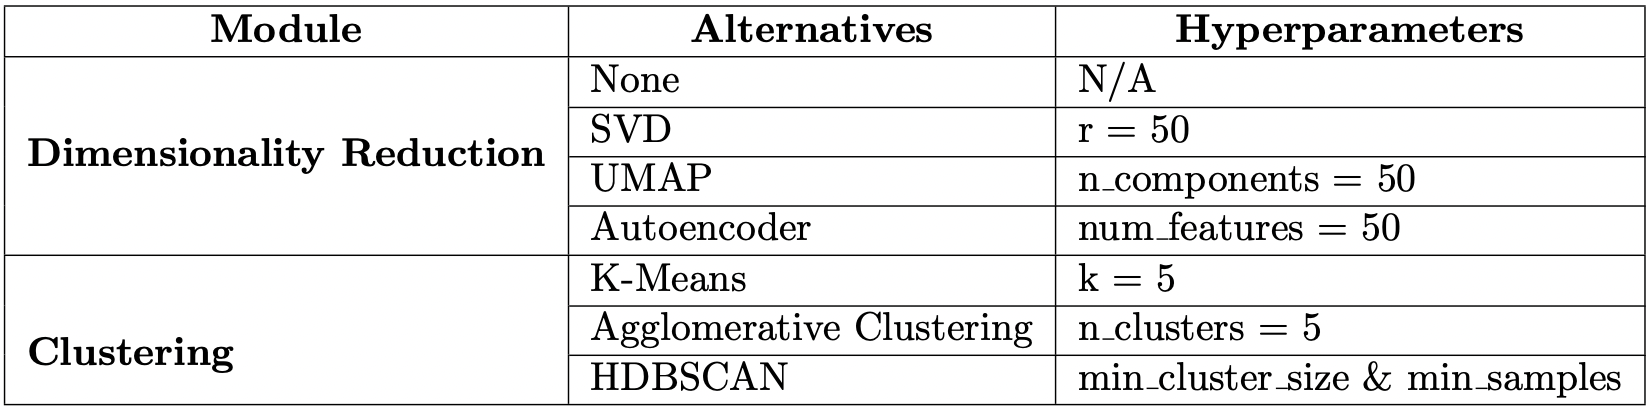

Using the grid above, the best results for different clustering algorithms with different dimensionality reduction techniques on the extracted image features are shown below:

***The grid for HDBSCAN***: <br>
minClusters = [200] <br>
minSamples = [20, 40]


*** The full results for each combination can be viewed in above cells ***

Best KMEANS scores:

'Homogeneity': 0.47828781665544173, <br>
'Completeness': 0.49429203168034336,<br>
'V-measure': 0.4861582460856243,<br>
'Adjusted Rand Index': 0.39803638259161356,<br>
'Adjusted mutual information score': 0.48544437660805734,<br>
'Rand Score': 0.7971381105261477

Dimensionality reduction method: UMAP<br>
No. of components: 50<br>
Cluster: 5


Best AGGLOMERATIVE CLUSTERING scores:

'Homogeneity': 0.46289484728283964,
'Completeness': 0.48520405989530135, <br>
'V-measure': 0.47378698046331336, <br>
'Adjusted Rand Index': 0.375806793954751, <br>
'Adjusted mutual information score': 0.473050766884461, <br>
'Rand Score': 0.7861848627910552},

Dimensionality reduction method: UMAP<br>
No. of components: 50<br>
Cluster: 5


Best HDBSCAN scores:
 
'Homogeneity': 0.4795458497901656,<br>
'Completeness': 0.4545916769800998,<br>
'V-measure': 0.46673545553549106,<br>
'Adjusted Rand Index': 0.3471197403721511,<br>
'Adjusted mutual information score': 0.4658479882162801,<br>
'Rand Score': 0.7892772719069782

Dimensionality reduction method: UMAP<br>
No. of components: 50<br>
min_samples: 20<br>
min_cluster_size: 200


Out of the three best combinations,

KMEANS with UAMP seems to better, then AGGLOMERATIVE CLUSTERING with UMAP and then HDBSCAN with UMAP.

***All comparisons are done using Adjusted Rand index and Rand Scores***



### Question 25

In [48]:
# Using full VGG features
X_train, X_test, y_train, y_test = train_test_split(f_all, y_all, test_size=0.2)
mlpClf = MLP(f_all.shape[1])
_, lossHistory = mlpClf.train(X_train, y_train)
results = mlpClf.eval(X_test, y_test)

100%|██████████| 100/100 [00:18<00:00,  5.45it/s]


torch.Size([734, 5])
(734,)
Accuracy: 0.885558583106267
Precision: 0.8851169609829797
Recall: 0.8804573088633741
F1 Score: 0.8824354514357271


2300


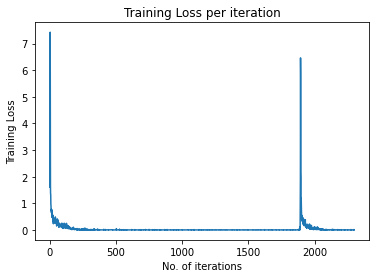

In [50]:
print(len(lossHistory))
plt.title("Training Loss per iteration")
plt.xlabel("No. of iterations")
plt.ylabel("Training Loss")
plt.plot(np.asarray(lossHistory))

In [43]:
# Working with dimensinality reduced features.
# All of the lcustering algorithms perform better with UMAP so choosing it. 
redFeatures = umap.UMAP(n_components=50, random_state=42, metric='cosine').fit_transform(VGGFeatures)


In [51]:
X_train, X_test, y_train, y_test = train_test_split(redFeatures, y_all, test_size=0.2)
mlpClf2 = MLP(redFeatures.shape[1])
_, lossHistory = mlpClf2.train(X_train, y_train)

100%|██████████| 100/100 [00:15<00:00,  6.52it/s]


In [52]:
results2 = mlpClf2.eval(X_test, y_test)

torch.Size([734, 5])
(734,)
Accuracy: 0.8174386920980926
Precision: 0.836476174133052
Recall: 0.819305812573243
F1 Score: 0.8155649804246113


In [54]:
# Using clustering to see the labels. 
# Using KMeans as it gave beter results in terms of rand score and adjusted rand
#  index compared to other clusterers.

classify = KMeans(n_clusters=5, random_state=42, max_iter=5000, n_init=50)
classify.fit(X_train)

preds = classify.predict(X_test)

In [56]:
scores = getScores(y_test, preds)
scores

{'Homogeneity': 0.5307977061484846,
 'Completeness': 0.539075917630815,
 'V-measure': 0.5349047853101441,
 'Adjusted Rand Index': 0.46554180782117577,
 'Adjusted mutual information score': 0.5316506767024964,
 'Rand Score': 0.8224459222857058}

### Answer 25

*** Test accuracy of the MLP classifier on the original VGG features: ***
Accuracy: 0.885558583106267 <br>
Precision: 0.8851169609829797<br>
Recall: 0.8804573088633741<br>
F1 Score: 0.8824354514357271<br>

*** Test accuracy of the MLP classifier on the reduced VGG features: ***

UMAP chosen since its the best performing method till the end of the project.

Dimensionality reduction method: UMAP <br>
Metric: cosine<br>
components: 50<br>

Accuracy: 0.8174386920980926 <br>
Precision: 0.836476174133052 <br>
Recall: 0.819305812573243 <br>
F1 Score: 0.8155649804246113 <br>

***The performance of the classifier is reduced when dimensionality reduction of the features was done. There is a drop of ~7-8 % which is quite significant***

***Correlation with clustering results***

Using the best combination i.e KMeans with UMAP, the scores of clustering with reduced dimensions are:

'Homogeneity': 0.5307977061484846,<br>
'Completeness': 0.539075917630815,<br>
'V-measure': 0.5349047853101441,<br>
'Adjusted Rand Index': 0.46554180782117577,<br>
'Adjusted mutual information score': 0.5316506767024964,<br>
'Rand Score': 0.8224459222857058

***Comparing the scores I found that K-means clustering is giving 82.24 % similarity compared to 81.74 % accuracy of the MLP classifier on the test set using dimensionality reduced features***